Extrae caracteristicas sin la distorcion donde es mayor a 0.9  y category = 0

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image, ImageOps, UnidentifiedImageError
import json
import os
import numpy as np
import jsonlines
from tqdm import tqdm

# Configuración de rutas
json_file = '/home/fbaquero/tesis/filtered_megadetector_metadata.json'
root_dir = '/media/databases/tiputini/'
output_file = '/home/fbaquero/tesis/tesisfinal/caracteristicasnodistorsion.jsonl'

# Verificar si CUDA está disponible y seleccionar el dispositivo adecuado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo preentrenado (ResNet-152) y remover la última capa
resnet152 = models.resnet152(pretrained=True)
modules = list(resnet152.children())[:-1]
resnet152 = nn.Sequential(*modules)
resnet152 = resnet152.to(device)
resnet152.eval()

# Asegurar que los parámetros del modelo no se actualicen durante la extracción de características
for p in resnet152.parameters():
    p.requires_grad = False

# Transformaciones para las imágenes
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Función para recortar la imagen usando las coordenadas del cropbox
def crop_image(image, bbox):
    left, top, right, bottom = bbox
    width = right - left
    height = bottom - top
    side_length = max(width, height)
    
    # Expandir el bounding box para que sea cuadrado, centrado en el objeto
    left = left - (side_length - width) // 2
    right = right + (side_length - width) // 2
    top = top - (side_length - height) // 2
    bottom = bottom + (side_length - height) // 2

    # Ajustar los límites para asegurarse de que están dentro de los bordes de la imagen
    left = max(left, 0)
    top = max(top, 0)
    right = min(right, image.width)
    bottom = min(bottom, image.height)

    cropped_image = image.crop((left, top, right, bottom))
    
    return cropped_image

# Función para extraer características
def extract_features(image, model):
    img_t = preprocess(image).to(device)
    batch_t = torch.unsqueeze(img_t, 0)
    
    with torch.no_grad():
        features = model(batch_t)
    return features.cpu().numpy().flatten().tolist()

# Leer el archivo JSON
with open(json_file) as f:
    data = json.load(f)

# Crear el archivo JSONL de salida
with jsonlines.open(output_file, mode='w') as writer:
    for entry in tqdm(data, desc="Procesando imágenes"):
        image_path = os.path.join(root_dir, entry['paths'][0])
        
        try:
            # Abrir la imagen original
            original_image = Image.open(image_path).convert('RGB')
        except (OSError, UnidentifiedImageError) as e:
            print(f"Error al abrir la imagen {image_path}: {e}")
            continue
        
        # Seleccionar detecciones que cumplan con los criterios
        for detection in entry['detectors']['megadetectorV5']['output']['detections']:
            categories = detection['category']
            confidences = detection['confidence']
            bboxes = detection['bbox']
            
            for i, (category, confidence) in enumerate(zip(categories, confidences)):
                if category == 0 and confidence >= 0.9:
                    bbox = bboxes[i]
                    cropped_image = crop_image(original_image, bbox)
                    features = extract_features(cropped_image, resnet152)
                    # Agregar características al objeto de detección
                    detection['features'] = features
        
        # Escribir la entrada modificada al archivo JSONL
        writer.write(entry)

print(f"Extracción de características completada. Los resultados se han guardado en {output_file}")


/home/fbaquero/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fbaquero/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Procesando imágenes:   2%|█▎                                                       | 2294/97409 [01:15<57:15, 27.69it/s]

Error al abrir la imagen /media/databases/tiputini/original_db/Pictures 2004.2008/Saladeros/Harpia1800/HS-B-06-10-18-2-45-Agopac.JPG: broken data stream when reading image file


Procesando imágenes:   5%|██▉                                                    | 5266/97409 [02:56<1:06:28, 23.10it/s]

Error al abrir la imagen /media/databases/tiputini/original_db/Pictures 2004.2008/Saladeros/Harpia1800/HS-C-08-11-12-0349-Mazame.JPG: image file is truncated (2213 bytes not processed)


Procesando imágenes:  11%|█████▉                                                  | 10276/97409 [05:48<46:52, 30.98it/s]

Error al abrir la imagen /media/databases/tiputini/original_db/Pictures 2004.2008/Senderos/M3600/M3600-B-06-08-24-1401-Psocre.JPG: broken data stream when reading image file


Procesando imágenes: 100%|████████████████████████████████████████████████████████| 97409/97409 [39:32<00:00, 41.07it/s]

Extracción de características completada. Los resultados se han guardado en /home/fbaquero/tesis/tesisfinal/caracteristicasnodistorsion.jsonl


/home/fbaquero/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


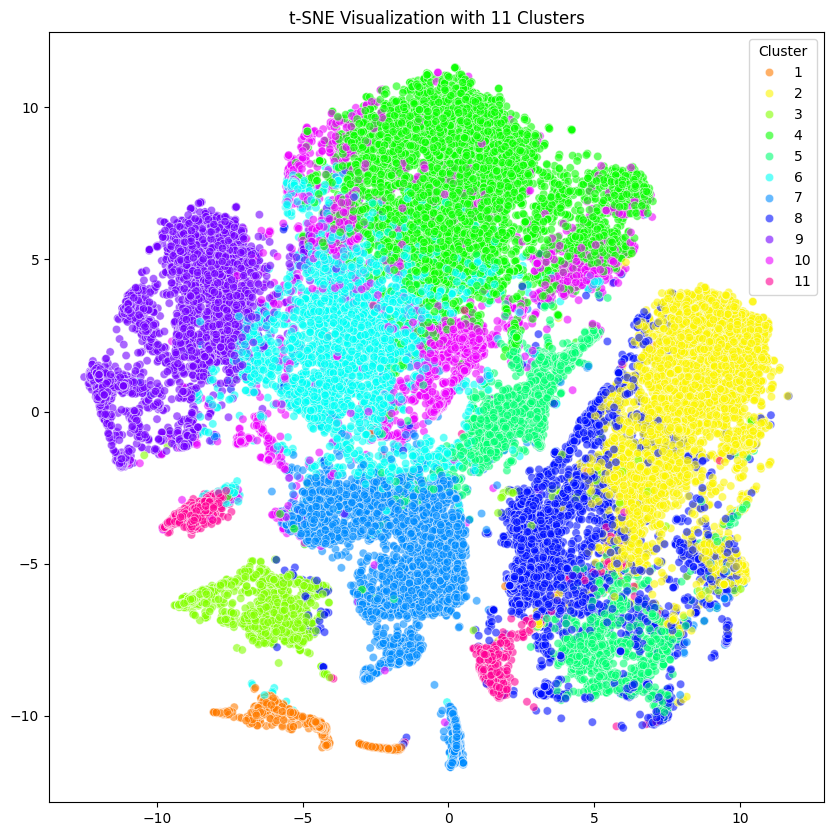

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import jsonlines

# Configuration of paths
features_file = '/home/fbaquero/tesis/tesisfinal/nodistorcion.jsonl'

# Read features from the JSONL file
features = []
with jsonlines.open(features_file) as reader:
    for obj in reader:
        for detection in obj['detectors']['megadetectorV5']['output']['detections']:
            if 'features' in detection:
                features.append(detection['features'])

features = np.array(features)

# Function to visualize t-SNE with cluster labels adjusted from 1 to 11
def plot_tsne(data, num_clusters=11):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(data)

    # Adjust labels from 0-10 to 1-11
    labels += 1

    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    tsne_results = tsne.fit_transform(data)
    
    plt.figure(figsize=(10, 10))
    scatter = sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1], 
        hue=labels,
        palette=sns.color_palette("hsv", num_clusters),
        legend="full",
        alpha=0.6
    )
    scatter.set_title('t-SNE Visualization with 11 Clusters')
    plt.legend(title='Cluster')
    plt.show()

# Execute the visualization for 11 clusters
plot_tsne(features)
